## Road Surface Classifier Inference Example

This is a quick script to perform inference with our trained model, so we can see how well it works!

In [2]:
# Hacky way to get PLMCNN in scope
import sys; sys.path.append('./model')

import pathlib

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from model.data_augmentation import PreProcess
from model.road_surface_dataset import RoadSurfaceDataset
from model.data_augmentation import PreProcess

# Input model and checkpoint paths (checkpoint contains the weights for inference)
# Since these files are so large, they are not in source control.
# Reach out to me if you'd like them.
model_path = pathlib.Path('/data/road_surface_classifier/results/20221229_194726Z/model.pth')
assert model_path.exists()
ckpt_path = pathlib.Path('/data/road_surface_classifier/results/20221229_194726Z/model-epoch=09-val_loss=1.56972.ckpt')
assert ckpt_path.exists()
ds_path = pathlib.Path('/data/road_surface_classifier/dataset/dataset_val.csv')
assert ds_path.exists()

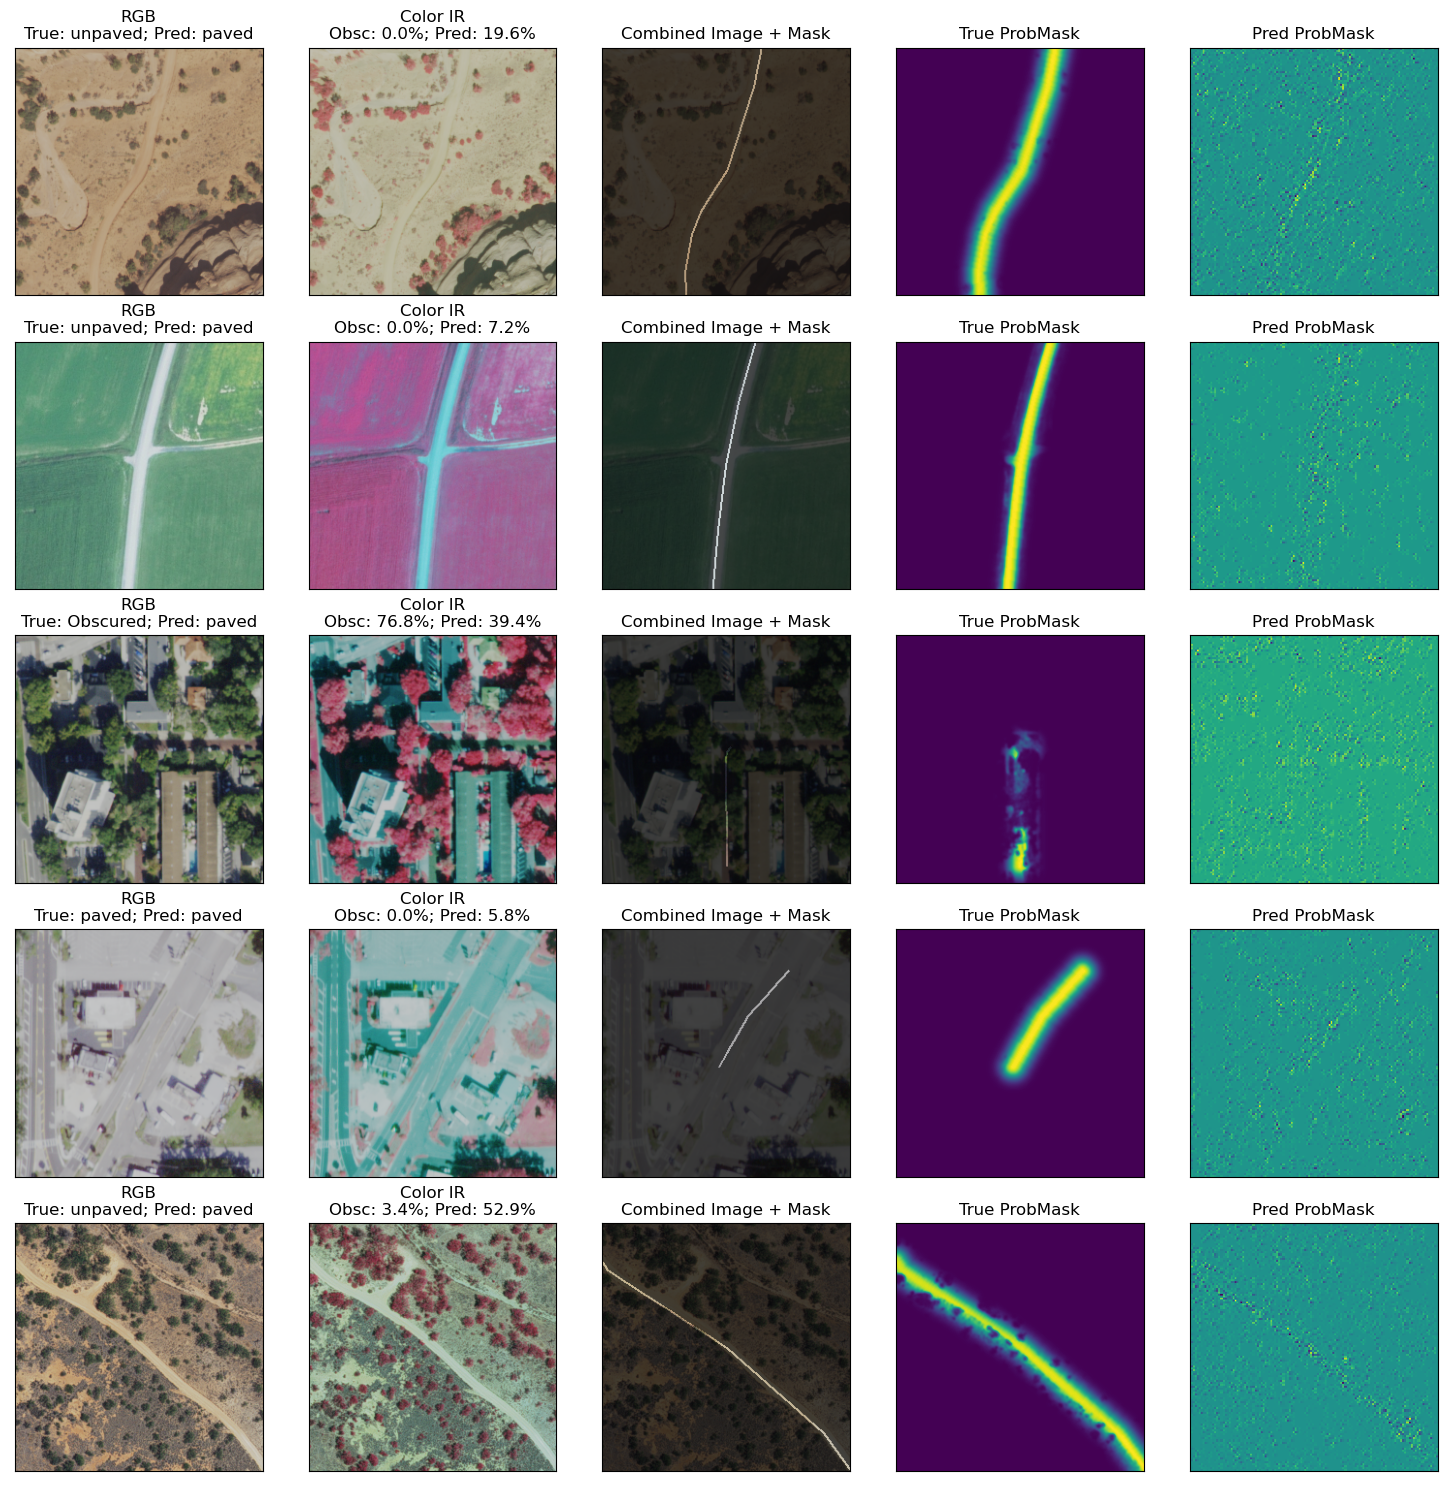

In [36]:
# Load model and checkpoint, set to eval (inference) mode
model = torch.load(model_path).load_from_checkpoint(ckpt_path)
model.eval()

# Get label array (it's built into model)
labels = model.__dict__.get('labels')

rows = 5
fig, ax = plt.subplots(rows, 5, sharex=True, sharey=True, figsize=(3*5, 3*rows))
fig.tight_layout()

for _ax in ax.flatten():
    _ax.xaxis.set_visible(False)
    _ax.yaxis.set_visible(False)

# Import dataset
preprocess = PreProcess()
val_ds = RoadSurfaceDataset(str(ds_path),
    transform=preprocess, limit=rows)
val_dl = DataLoader(val_ds, num_workers=16, batch_size=1, shuffle=True)

# Get truth and predictions using the dataloader
for i, (x, features) in enumerate(iter(val_dl)):

    # Get mask and image
    xm = x[:, 4:5, :, :]
    xpm = x[:, 5:6, :, :]
    x = x[:, 0:4, :, :]

    # Get true label
    y_true = features.numpy()[0]

    # Transform image in masl
    x_p = (np.moveaxis(x.numpy(), 1, -1)[0, ...] * 255.).astype(np.uint8)
    xm_p = np.moveaxis(xm.numpy(), 1, -1)[0, ...]
    xpm_p = np.moveaxis(xpm.numpy(), 1, -1)[0, ...]

    # Predict with the model
    m, y_pred = model(x, xm)
    m_p = np.moveaxis(m.detach().numpy(), 1, -1)[0, ...]

    y_pred_sm = torch.softmax(y_pred.reshape(1, -1), 1)[0]
    y_pred = y_pred.detach().numpy()     # type: ignore
    y_pred_sm = y_pred_sm.detach().numpy()     # type: ignore

    # Plot the result, highlighting the road with the mask
    ax[i][0].set_title('RGB\nTrue: %s; Pred: %s' % (labels[np.argmax(y_true)], labels[np.argmax(y_pred[(0, 1)])]))
    ax[i][0].imshow(np.uint8(x_p[..., (0, 1, 2)]))
    ax[i][1].set_title('Color IR\nObsc: %.1f%%; Pred: %.1f%%' % (y_true[2] * 100, y_pred_sm[2] * 100))
    ax[i][1].imshow(np.uint8(x_p[..., (3, 0, 1)]))
    ax[i][2].set_title('Combined Image + Mask')
    ax[i][2].imshow(np.uint8(x_p[..., (0, 1, 2)] * (0.33 + 0.67 * xm_p)))
    ax[i][3].set_title('True ProbMask')
    ax[i][3].imshow(xpm_p)
    ax[i][4].set_title('Pred ProbMask')
    ax[i][4].imshow(m_p)

plt.show()